<a href="https://colab.research.google.com/github/piaosan78/AIFFEL_Quest/blob/master/Exploration_CR5/Chapter_8/GAN_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Google Colab에서 GPU 설정
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [24]:
import tensorflow as tf
import time
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 로딩 및 전처리
(train_images, train_labels), (_, _) = cifar10.load_data()
train_images = train_images.astype('float32')

In [25]:
train_images = (train_images - 127.5) / 127.5  # 이미지를 [-1, 1]로 정규화

In [26]:
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [37]:
NOISE_DIM = 100

In [38]:
# 2. 생성자와 판별자 모델 생성
def make_generator_model():
    model = Sequential([
        Dense(256, use_bias=False, input_shape=(100,)),
        BatchNormalization(),
        LeakyReLU(),

        Dense(8*8*128, use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((8, 8, 128)),

        Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [39]:
def make_discriminator_model():
    model = Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        LeakyReLU(),
        Dropout(0.3),

        Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(),
        Dropout(0.3),

        Flatten(),
        Dense(1)
    ])
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

In [40]:
# 3. 손실 함수와 최적화 도구 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [41]:
# 4. 훈련 루프 정의
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Accuracy
        real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
        fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [42]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)

        print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}, Real Accuracy: {real_accuracy * 100}, Fake Accuracy: {fake_accuracy * 100}')

        # 15 에포크마다 생성된 이미지 저장
        if (epoch + 1) % 15 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

    # 마지막 에포크 후 생성된 이미지 저장
    generate_and_save_images(generator, epochs, seed)

In [43]:
# 5. 훈련 실행 및 가짜 이미지 시각화
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [44]:
# 훈련에 사용할 상수 설정
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

In [45]:
# 시각화를 위한 노이즈 벡터 생성
seed = tf.random.normal([num_examples_to_generate, noise_dim])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.68 µs
Epoch 1, Gen Loss: 1.7582405805587769, Disc Loss: 0.4901285767555237, Real Accuracy: 81.25, Fake Accuracy: 100.0
Time for epoch 1 is 15.728071451187134 sec
Epoch 2, Gen Loss: 1.6213750839233398, Disc Loss: 0.5332426428794861, Real Accuracy: 83.75, Fake Accuracy: 99.609375
Time for epoch 2 is 10.987656593322754 sec
Epoch 3, Gen Loss: 1.6464273929595947, Disc Loss: 0.5448733568191528, Real Accuracy: 82.5, Fake Accuracy: 99.21875
Time for epoch 3 is 11.082298994064331 sec
Epoch 4, Gen Loss: 1.578932285308838, Disc Loss: 0.655430257320404, Real Accuracy: 78.75, Fake Accuracy: 92.578125
Time for epoch 4 is 10.827871084213257 sec
Epoch 5, Gen Loss: 1.4382469654083252, Disc Loss: 0.7524360418319702, Real Accuracy: 67.5, Fake Accuracy: 100.0
Time for epoch 5 is 10.67706823348999 sec
Epoch 6, Gen Loss: 1.4946051836013794, Disc Loss: 0.7412664890289307, Real Accuracy: 70.0, Fake Accuracy: 99.21875
Time for epoch 6 is 10.612363338470

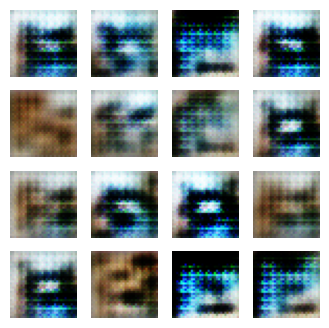

In [46]:
# GAN 훈련
%time
train(train_dataset, EPOCHS)

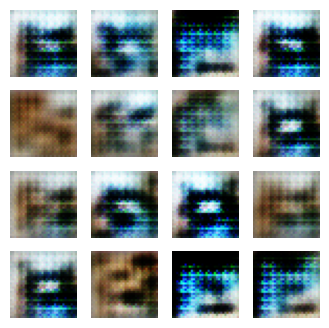

In [47]:
# 마지막 훈련 에폭 후 생성된 이미지 시각화
generate_and_save_images(generator, EPOCHS, seed)